This analysis is based on one of my rencent shopping experience on Amazon. Waking up one Saturday morning with dry throat, I decide I need to get a humidifer to adapt to California's dry climate. Without a second thought, I went to Amazon. 15 minutes is what I assume would take for this easy task. However, it turns out I highly underestimate the compliexity of shopping for unfamiliar items on Amazon. Sure thing Amazon's extremely informative websites offer a nice way to help custmer know every product and making decisions. However those explosive information scheme sometimes can make it very difficult to efficiently absorb most useful one. This is especially true with customer reviews. Popular pruducts can easily get hundreds of pages of reviews, how much to read and how to get most unbiased product discription can be tricky to decide. Therefore, I decide to grab some handy data analysis tools to help me browse through the customer reviews, and this turns out to be much more fun than shopping only. Got some very interesting observations and probably something Amazon can work on to improve shopping experience. 

Load some packages first, where lxml, json, requests are for scraping Amazon website, pytagcloud and wordcloud are two great packages for making word clouds, else are some natural language processing and data visualize tool box. 

In [1]:
from lxml import html
import json
import requests
import re
from dateutil import parser as dateparser
from nltk import Text, FreqDist, corpus, pos_tag, PorterStemmer, bigrams, trigrams
import matplotlib.pyplot as plt
import pandas as pd
from pytagcloud import create_tag_image, make_tags
import sys
from IPython.display import Image
import numpy as np
import pandas as pd
from collections import Counter
import seaborn as sns
from os import path
from scipy.misc import imread
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
matplotlib inline

### Let's get the customer reviews. 
Select product is a best seller from amazon "whole room humidifer" (https://www.amazon.com/Ultrasonic-Cool-Mist-Humidifier-Whisper-quiet) . It has been on Amazon since 2015, receives more than 500 pages of customer review.

In [3]:
urlbase = 'https://www.amazon.com/Ultrasonic-Cool-Mist-Humidifier-Whisper-quiet/product-reviews/B013IJPTFK/ref=cm_cr_arp_d_viewopt_srt?ie=UTF8&reviewerType=avp_only_reviews&sortBy=recent&pageNumber='
urls = []
for page in np.arange(1,544):
    url = urlbase+str(page)
    urls.append(url)

In [4]:
def getReviews(urls):
    # get reviews from provied urls
    # input urls -- set of url
    # output review_list -- dict of reviews, contains date, rate, text and location
    reviews_list = []
    for url in urls:
        headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/42.0.2311.90 Safari/537.36'}
        page = requests.get(url, headers=headers)
        page_response = page.text
        parser = html.fromstring(page_response)
        XPATH_REVIRETEXT = '//span[contains(@class,"review-text")]//text()'
        XPATH_REVIEWDATE = './/a[contains(@href,"/profile/")]/parent::span/following-sibling::span/text()'
        XPATH_REVIEWRATE = './/i[@data-hook="review-star-rating"]//text()'
        # get review text, date and rate
        reviews_text = parser.xpath(XPATH_REVIRETEXT)
        reviews_date = parser.xpath(XPATH_REVIEWDATE)
        reviews_rate = parser.xpath(XPATH_REVIEWRATE)
        reviews_rate = [re.sub(' out of 5 stars','',review_rate) for review_rate in reviews_rate]
        reviews_date = [re.sub('on ', '', review_date) for review_date in reviews_date]
        
        # get reviewer location, note this might be a highly sparse field
        reviews_location = []
        XPATH_REVIEWERPROFILE = './/a[contains(@href,"/profile/")]//@href'
        hrefs = parser.xpath(XPATH_REVIEWERPROFILE)
        for href in hrefs:
            USERURL = 'https://www.amazon.com' + href
            userpage = requests.get(USERURL,headers=headers)
            userparser = html.fromstring(userpage.content)
            XPATH_LOCATION = '//div[contains(@class,"location")]//text()'
            reviews_location.append(userparser.xpath(XPATH_LOCATION))
           
        reviews_dict =  [{'date':review_date,
                           'rate':review_rate,
                           'text':review_text,
                            'location': re.sub('\\n','',''.join(review_location))}
                                for review_date, review_rate, review_text, review_location in zip(reviews_date, reviews_rate, reviews_text, reviews_location)]
        reviews_list.extend(reviews_dict)
        
    return reviews_list

In [8]:
reviews_list = getReviews(urls)

KeyboardInterrupt: 

Put the review_list into pandas dataframe format, and creat some additional fields (month, year, day) 

In [9]:
df = pd.DataFrame(reviews_list)
df['month'] = df['date'].apply(lambda x: ''.join(re.findall('[^0-9,]',x)))
df['year'] = df['date'].apply(lambda x: ''.join(re.sub('.*, ','',x)))
df['day'] = df['date'].apply(lambda x: ''.join(re.sub('[a-zA-Z]* ','',re.sub(',.*','',x))))
df['rate'] = df['rate'].apply(lambda x: float(x))
df.head()

,date,location,rate,text,month,year,day
0,"April 30, 2017",,5.0,"Been using for 2 weeks straight night and day,...",April,2017,30
1,"April 30, 2017",,5.0,Helped kids breath better at night. I would hi...,April,2017,30
2,"April 30, 2017",,5.0,Very good humidifier but must be cleaned frequ...,April,2017,30
3,"April 29, 2017",,1.0,It worked for 1 night: that's it. The followin...,April,2017,29
4,"April 29, 2017",,1.0,Don't waste your money as I did!,April,2017,29


Recreate amazon's rate overview

Average rate socre: 4.3


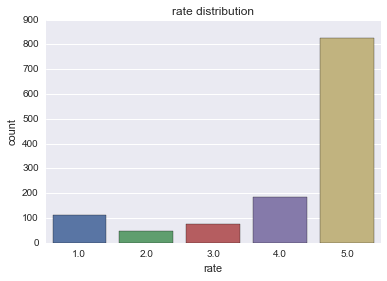

In [10]:
sns.countplot(df['rate'])
plt.title('rate distribution')
print "Average rate socre: %.1f" %(df['rate'].mean())

More than the generate average rates, let's break it down to different years. Since different year might have difernt sale amount, let's also plot the normalized distribution of rate scores. 

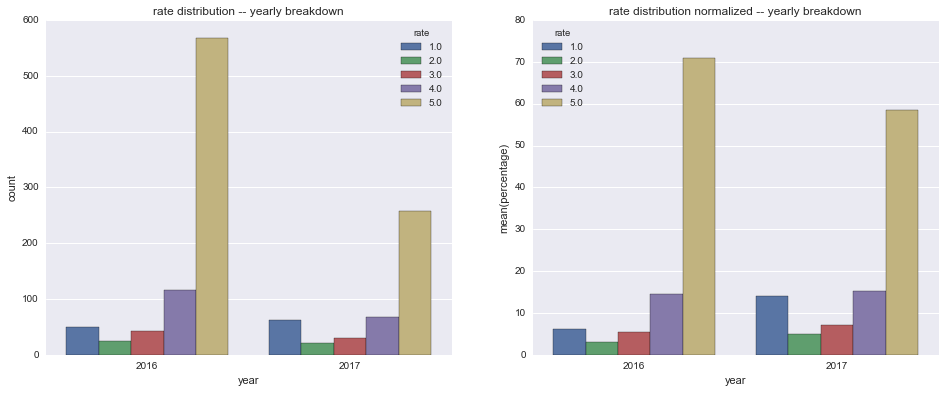

In [11]:
plt.figure(figsize=[16,6])
plt.subplot(1,2,1)
sns.countplot(df['year'],hue=df['rate'])
plt.title('rate distribution -- yearly breakdown')
plt.subplot(1,2,2)
rate_counts = df.groupby(['year'])['rate'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
sns.barplot(x="year", y='percentage', hue='rate', data=rate_counts)
plt.title('rate distribution normalized -- yearly breakdown')

In [12]:
print 'months in 2015'
print df[df['year']=='2015']['month'].value_counts()
print 
print 'months in 2016'
print df[df['year']=='2016']['month'].describe()
print
print 'months in 2017'
print df[df['year']=='2017']['month'].value_counts()

months in 2015
Series([], Name: month, dtype: int64)

months in 2016
count            801
unique            12
top       December  
freq             151
Name: month, dtype: object

months in 2017
January       129
February      120
April         100
March          90
Name: month, dtype: int64


So we see this humidifier has been on market for 2 months and 4 months in 2015 and 2017 respectively, full year in 2016. This rerun at May 1st 2017 doesn't contain reviews from 2015.
Rate percentage distribution looks quite similar, except 1 star rate in 2017 is much higher than other years. This is very interesting to know, does the product quality drop in 2017? Before drawing any conclusion, given the fact that humidifier could be a seasonal product, let's investigate into how average rate varies among different months. 

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


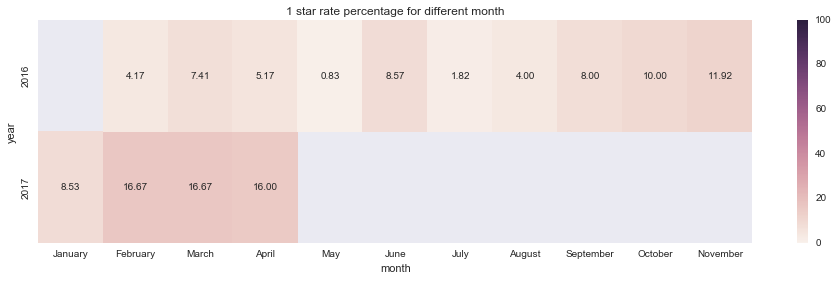

In [13]:
plt.figure(figsize=[16,4])
rate_counts = df.groupby(['year','month'])['rate'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
oneStarRate = rate_counts[rate_counts['rate']==1]
month_dict = {'January':1,'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 
            'September':9,'October':10, 'November':11, 'December':12}

oneStarRate['month'] = oneStarRate['month'].apply(lambda x: re.sub('[^a-zA-Z]','',x))
oneStarRate['monthint'] = oneStarRate['month'].replace(month_dict)

oneStarRate = oneStarRate.sort_values(by='monthint')

oneStarPivot = oneStarRate.pivot('year','monthint','percentage')
vmin, vmax = oneStarPivot.values.min(),oneStarPivot.values.max()
plt.figure(figsize = [16,4])
sns.heatmap(oneStarPivot,annot=True, fmt=".2f", vmin=0, vmax=100, xticklabels = ['January','February', 'March', 'April', 'May', 'June', 'July', 'August', 
            'September','October', 'November', 'December'])
plt.xlabel('month')
plt.title('1 star rate percentage for different month')

Looks like the increasing 1 start rate is not related to some particular easier angry post-festival months. In fact we can see a clearly increasing trend in 1 star rate percentages since October 2016. Some second thoughts would be considered here before buying this product.  

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

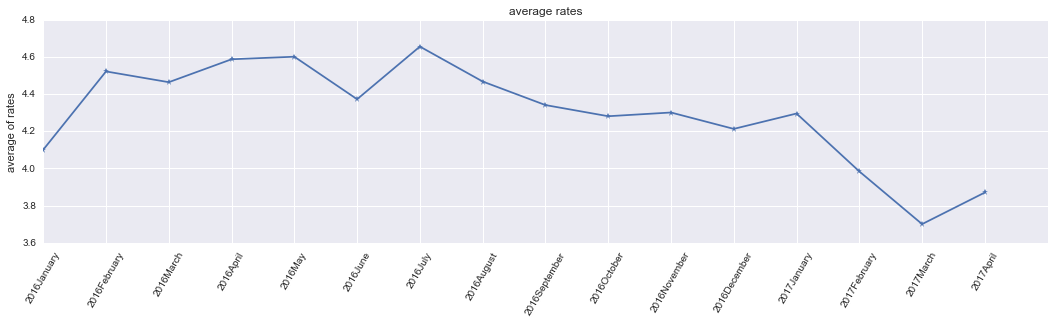

In [14]:
meanRate = df.groupby(['year','month'])['rate'].mean().rename('meanrate').reset_index()
meanRate['month'] =  meanRate['month'].apply(lambda x: re.sub('[^a-zA-Z]','',x))

meanRate['monthint'] = meanRate['month'].replace(month_dict)
meanRate = meanRate.sort_values(by = ['year','monthint'])

meanRate.index = range(len(meanRate))
plt.figure(figsize = [18,4])
plt.plot(meanRate['meanrate'],'-*')
plt.title('average rates')
plt.xlabel('')
plt.ylabel('average of rates')
tt = [''.join(m) for m in meanRate[['year','month']].values]
plt.xticks(np.arange(17),tt)
locs, labels = plt.xticks()
plt.setp(labels, rotation=60)

Plot of average rates also suggest an decreasing of customers' satisfaction of this product. 
Let's take a look at what people are saying about this product besides how many stars they like to offer. 

I'm going to geneate some word clouds about hot words people like to use in their reviews. In word clouds, font size is propotional to the word frequencies. 

Review word clouds for year 2015, 2016 and 2017.

In [15]:
review2017 = ''.join(df[df['year']=='2017']['text'])
review2016 = ''.join(df[df['year']=='2016']['text'])
review2015 = ''.join(df[df['year']=='2015']['text'])

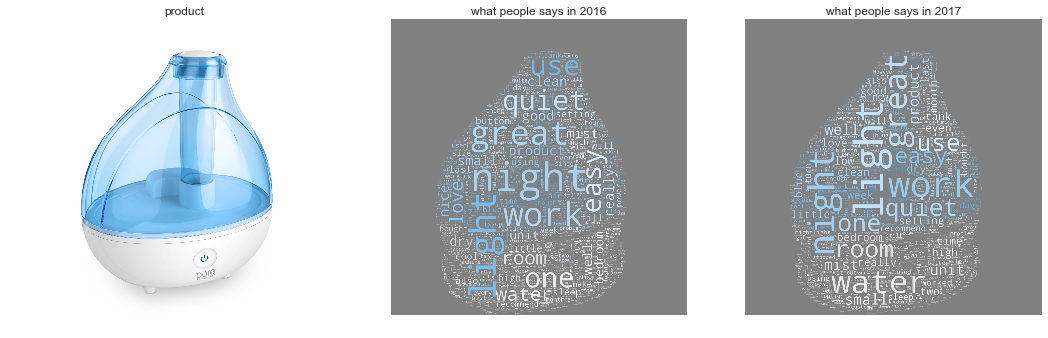

In [16]:
#load product image
mask = imread('/Users/linamiao/Downloads/mask.jpg')

#generate wordcloud for different years
fig = plt.figure(figsize=(18,10))
plt.subplot(1,3,1)
plt.imshow(mask)
plt.axis("off")
plt.title('product')

"""
wordcloud = WordCloud(background_color='grey',max_words=2000,mask=mask, 
                     stopwords=STOPWORDS.add("humidifier")).generate(review2015)
image_colors = ImageColorGenerator(mask)
plt.subplot(1,4,2)
plt.imshow(wordcloud.recolor(color_func=image_colors))
plt.axis("off")
plt.title('what people says in 2015')
"""

wordcloud = WordCloud(background_color='grey',max_words=2000,mask=mask, 
                     stopwords=STOPWORDS.add("humidifier")).generate(review2016)
image_colors = ImageColorGenerator(mask)
plt.subplot(1,3,2)
plt.imshow(wordcloud.recolor(color_func=image_colors))
plt.axis("off")
plt.title('what people says in 2016')


wordcloud = WordCloud(background_color='grey',max_words=2000,mask=mask, 
                     stopwords=STOPWORDS.add("humidifier")).generate(review2017)
image_colors = ImageColorGenerator(mask)
plt.subplot(1,3,3)
plt.imshow(wordcloud.recolor(color_func=image_colors))
plt.axis("off")
plt.title('what people says in 2017')


'light, night, quiet, small, great, easy, word' are some preliminary impression we get from those word clouds, looks like a very nice product. 

To understand more about the reviews, let's look at more interesting 'Love' and 'Hate' clouds -- word clouds seperated based on if reviewers love(4 stars or more) or hate(2 stars or less) the product.

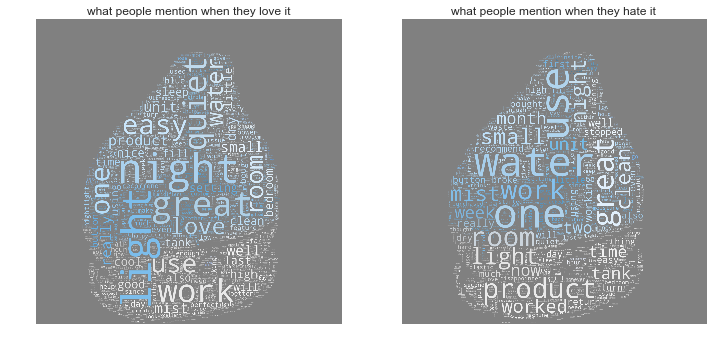

In [17]:
reviewLove = ''.join(df[df['rate']>=4]['text'])
reviewHate = ''.join(df[df['rate']<=2]['text'])
#more word clouds
wordcloud = WordCloud(background_color='grey',max_words=2000,mask=mask, 
                     stopwords=STOPWORDS.add("humidifier")).generate(reviewLove)
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(wordcloud.recolor(color_func=image_colors))
plt.axis("off")
plt.title('what people mention when they love it')


wordcloud = WordCloud(background_color='grey',max_words=2000,mask=mask, 
                     stopwords=STOPWORDS.add("humidifier")).generate(reviewHate)
image_colors = ImageColorGenerator(mask)
plt.subplot(1,2,2)
plt.imshow(wordcloud.recolor(color_func=image_colors))
plt.axis("off")
plt.title('what people mention when they hate it')

We see those two clouds share many common words, which makes sense since most people would not only leave reviews with pure love or hate words. Positive and negative would very likely share some neutral useful product description. Let's bring in some word clouds about words they uniquely have and share.

In [18]:
def getTokens(text):
    text = re.sub('[.,!:;">-?()--\']',' ',''.join(text)).split()
    text = [t.lower()
           for t in text
               if t not in corpus.stopwords.words('english')]
    return text

In [19]:
tokenLove = getTokens(reviewLove);
tokenHate = getTokens(reviewHate);

tokenLove_counter = Counter(tokenLove)
tokenHate_counter = Counter(tokenHate)

common = set(tokenLove).intersection(set(tokenHate))
tmp = tokenLove_counter.copy()
for word in common:
    del tokenLove_counter[word]
    del tokenHate_counter[word]
tokenCommon_counter = tmp - tokenLove_counter

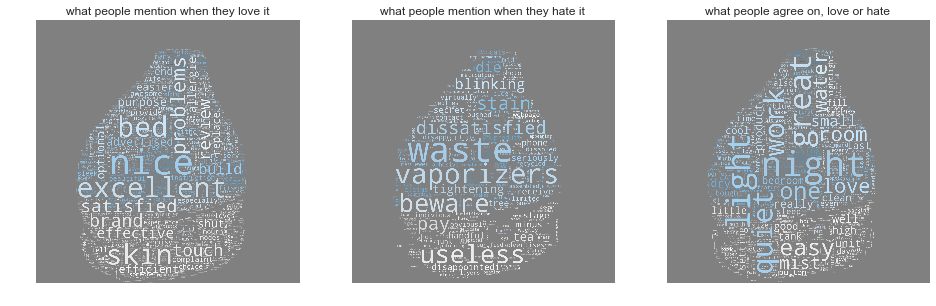

In [20]:
stopwords = STOPWORDS.copy()
stopwords.add('will')    
stopwords.add('now')   
stopwords.add('followed')
stopwords.add('live')
stopwords.add('use')
    
wordcloud = WordCloud(background_color='grey',max_words=2000,mask=mask, 
                     stopwords=stopwords).generate(' '.join(tokenLove_counter.elements()))
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(16,10))
plt.subplot(1,3,1)
plt.imshow(wordcloud.recolor(color_func=image_colors))
plt.axis("off")
plt.title('what people mention when they love it')


wordcloud = WordCloud(background_color='grey',max_words=2000,mask=mask, 
                     stopwords=stopwords).generate(' '.join(tokenHate_counter.elements()))
image_colors = ImageColorGenerator(mask)
plt.subplot(1,3,2)
plt.imshow(wordcloud.recolor(color_func=image_colors))
plt.axis("off")
plt.title('what people mention when they hate it')


wordcloud = WordCloud(background_color='grey',max_words=2000,mask=mask, 
                     stopwords=stopwords).generate(' '.join(tokenCommon_counter.elements()))
image_colors = ImageColorGenerator(mask)
plt.subplot(1,3,3)
plt.imshow(wordcloud.recolor(color_func=image_colors))
plt.axis("off")
plt.title('what people agree on, love or hate')


Most interesting is the common word one. We seem to missing some content with those isolated words, let's look at some concordance of some interesting words. 

In [21]:
print Text(tokenLove).concordance('light')
print Text(tokenHate).concordance('light')

Displaying 25 of 391 matches:
 the water lasts one night high love light feature not happy leaks every time i
weeks straight night day works great light feature cool it didnt work first cuz
tion settings low high speed & night light it lasts whole night low speed setti
month my baby sick i trying turn red light time full tank of course late return
we using nursery once covered bright light duct tape love even light settings s
red bright light duct tape love even light settings still bright very quiet lig
ght settings still bright very quiet light so bright had humidifier almost year
 bought far it would nice blue power light night light bright distracting perso
it would nice blue power light night light bright distracting person sleep well
ble easy fill assembly i really like light base detaches actual cord/plug the t
he timer feature well blue glo night light fantastic great value helpful winter
erfect daughter room she loves night light choose mist level very good purchase
ish way ei

In [22]:
def n_concordance_tokenised(text,phrase,left_margin=5,right_margin=5, num=10):
    #concordance replication via https://simplypython.wordpress.com/2014/03/14/saving-output-of-nltk-text-concordance/

    phraseList=phrase.split(' ')

    c = nltk.ConcordanceIndex(text.tokens, key = lambda s: s.lower())

    #Find the offset for each token in the phrase
    offsets=[c.offsets(x) for x in phraseList]
    offsets_norm=[]
    #For each token in the phraselist, find the offsets and rebase them to the start of the phrase
    for i in range(len(phraseList)):
        offsets_norm.append([x-i for x in offsets[i]])
    #We have found the offset of a phrase if the rebased values intersect
    #--
    # http://stackoverflow.com/a/3852792/454773
    #the intersection method takes an arbitrary amount of arguments
    #result = set(d[0]).intersection(*d[1:])
    #--
    intersects=set(offsets_norm[0]).intersection(*offsets_norm[1:])

    concordance_txt = ([text.tokens[map(lambda x: x-left_margin if (x-left_margin)>=0 else 0,[offset])[0]:offset+len(phraseList)+right_margin]
                    for offset in intersects])

    outputs=[''.join([x+' ' for x in con_sub]) for con_sub in concordance_txt]
    return outputs[1:num]

def n_concordance(txt,phrase,left_margin=5,right_margin=5):
    tokens = nltk.word_tokenize(txt)
    text = nltk.Text(tokens)

    return

print n_concordance_tokenised(Text(tokenLove), 'night light', num=10)
print n_concordance_tokenised(Text(tokenHate), 'night light', num=10)


NameError: global name 'nltk' is not defined

In [29]:
import os
for fd in np.arange(141,255):
    os.close(fd)

Let's see if we can get more useful information by looking at some bigrams and trigrams other than isolated words. 

In [26]:
tokenLove = [w.lower() 
            for w in tokenLove 
                if w not in ['I','you', 'humidifier', 'bought','tried','used','purchased','the','i']]

freqdist = FreqDist(bigrams(tokenLove))
freqdist = freqdist.most_common(30)
fqdist = dict((' '.join(x),y) for (x,y) in freqdist)
texttags = make_tags(fqdist.items(), maxsize=45)
create_tag_image(texttags, 'bigramsfqdist.png', size=(600,600), fontname='Lobster')

freqdist = FreqDist(trigrams(tokenLove))
freqdist = freqdist.most_common(30)
fqdist = dict((' '.join(x),y) for (x,y) in freqdist)
texttags = make_tags(fqdist.items(), maxsize=35)
create_tag_image(texttags, 'trigramsfqdist.png', size=(600,600), fontname='Lobster')


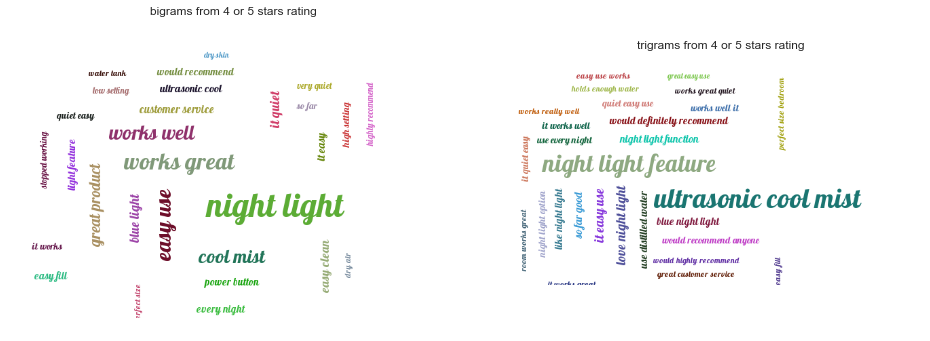

In [27]:
plt.figure(figsize=(16,14))

plt.subplot(1,2,1)
plt.imshow(imread('/Users/linamiao/bigramsfqdist.png'))
plt.axis('off')
plt.title('bigrams from 4 or 5 stars rating')

plt.subplot(1,2,2)
plt.imshow(imread('/Users/linamiao/trigramsfqdist.png'))
plt.axis('off')
plt.title('trigrams from 4 or 5 stars rating')

In [21]:
tokenHate = [w.lower() 
            for w in tokenHate 
                if w not in ['I','you', 'humidifier', 'bought','tried','used','purchased','the','i']]

freqdist = FreqDist(bigrams(tokenHate))
freqdist = freqdist.most_common(30)
fqdist = dict((' '.join(x),y) for (x,y) in freqdist)
texttags = make_tags(fqdist.items(), maxsize=35)
create_tag_image(texttags, 'bigramsfqdistHate.png', size=(600,600), fontname='Lobster')

freqdist = FreqDist(trigrams(tokenHate))
freqdist = freqdist.most_common(30)
fqdist = dict((' '.join(x),y) for (x,y) in freqdist)
texttags = make_tags(fqdist.items(), maxsize=20)
create_tag_image(texttags, 'trigramsfqdistHate.png', size=(600,600), fontname='Lobster')



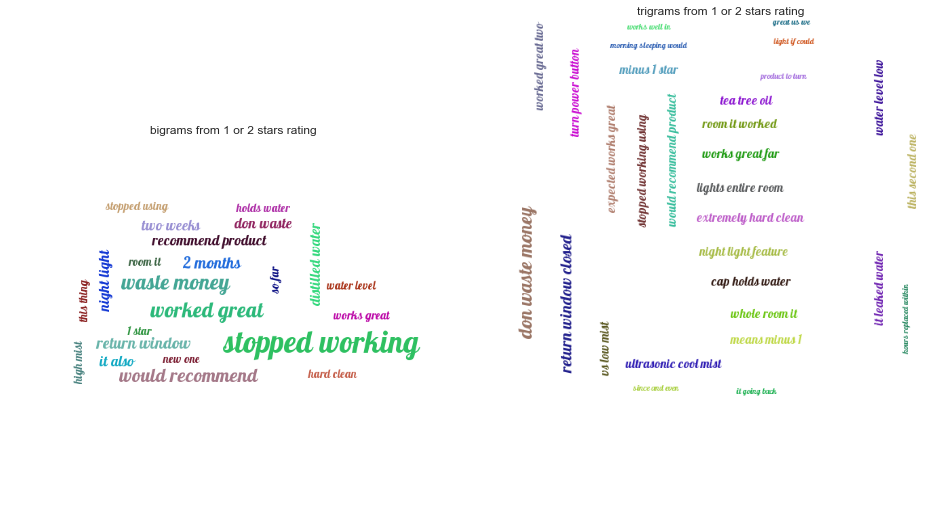

In [22]:
plt.figure(figsize=(16,14))

plt.subplot(1,2,1)
plt.imshow(imread('/Users/linamiao/bigramsfqdistHate.png'))
plt.axis('off')
plt.title('bigrams from 1 or 2 stars rating')

plt.subplot(1,2,2)
plt.imshow(imread('/Users/linamiao/trigramsfqdistHate.png'))
plt.axis('off')
plt.title('trigrams from 1 or 2 stars rating')

Bigrams with noun phrases

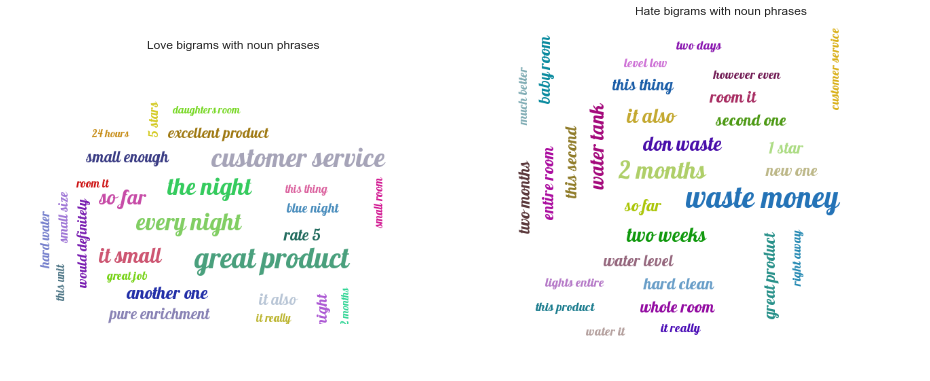

In [23]:
wordstag = pos_tag(tokenLove)
verbs = [word
        for (word,tag) in wordstag
            if tag.startswith('V')]
bigs = list(bigrams(tokenLove))

bigs = [w 
           for w in bigs
               if w[0] not in verbs and w[1] not in verbs ]
freqdist = FreqDist(bigs)
freqdist = freqdist.most_common(30)
fqdist = dict((' '.join(x),y) for (x,y) in freqdist)
texttags = make_tags(fqdist.items(), maxsize=35)
create_tag_image(texttags, 'nounLovebigrams.png', size=(600,600), fontname='Lobster')


plt.figure(figsize=(16,14))
plt.subplot(1,2,1)
plt.imshow(imread('/Users/linamiao/nounLovebigrams.png'))
plt.axis('off')
plt.title('Love bigrams with noun phrases')       

wordstag = pos_tag(tokenHate)
verbs = [word
        for (word,tag) in wordstag
            if tag.startswith('V')]
bigs = list(bigrams(tokenHate))

bigs = [w 
           for w in bigs
               if w[0] not in verbs and w[1] not in verbs ]
freqdist = FreqDist(bigs)
freqdist = freqdist.most_common(30)
fqdist = dict((' '.join(x),y) for (x,y) in freqdist)
texttags = make_tags(fqdist.items(), maxsize=35)
create_tag_image(texttags, 'nounHatebigrams.png', size=(600,600), fontname='Lobster')

plt.subplot(1,2,2)
plt.imshow(imread('/Users/linamiao/nounHatebigrams.png'))
plt.axis('off')
plt.title('Hate bigrams with noun phrases')       
